In [1]:
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets

zsh:1: no matches found: transformers[torch]


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from transformers import T5Tokenizer, T5ForSequenceClassification
from sklearn.metrics import accuracy_score



/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train = pd.read_csv('./training.csv')

train.isna().any()

text     False
label    False
dtype: bool

In [4]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

print("Before undersampling:", Counter(train['label']))

class_counts = Counter(train['label'])

# Set the target number of samples per class
target_samples = 3000

# Determine classes needing oversampling and undersampling
classes_to_resample = {cls: target_samples for cls, count in class_counts.items() if count < target_samples}
classes_to_keep = {cls: target_samples for cls, count in class_counts.items() if count >= target_samples}
print('Class to OverSample: ', classes_to_resample)
print("Class to UnderSample: ", classes_to_keep)
# Oversample minority classes
oversampler = RandomOverSampler(sampling_strategy=classes_to_resample)

# Undersample majority classes
undersampler = RandomUnderSampler(sampling_strategy=classes_to_keep)


train_text_resampled, train_labels_resampled = oversampler.fit_resample(np.array(train['text']).reshape(-1,1), train['label'])

print('After Oversample:' , Counter(train_labels_resampled))

train_text_resampled, train_labels_resampled = undersampler.fit_resample(train_text_resampled, train_labels_resampled)

# Check the class distribution after resampling
print('After Undersample:', Counter(train_labels_resampled))

Before undersampling: Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})
Class to OverSample:  {3: 3000, 2: 3000, 5: 3000, 4: 3000}
Class to UnderSample:  {0: 3000, 1: 3000}
After Oversample: Counter({1: 5362, 0: 4666, 3: 3000, 2: 3000, 5: 3000, 4: 3000})
After Undersample: Counter({0: 3000, 1: 3000, 2: 3000, 3: 3000, 4: 3000, 5: 3000})


In [5]:
from sklearn.model_selection import train_test_split
train_labels_resampled = np.array(train_labels_resampled)
X_train, X_temp, y_train, y_temp = train_test_split(train_text_resampled,train_labels_resampled,test_size=0.3,random_state=42)
X_val, X_test, y_val,y_test =  train_test_split(X_temp,y_temp,test_size=0.5, random_state=42)

In [6]:
!pip install sentencepiece

In [7]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
def tokenize(data):
  data = [sentence[0] for sentence in data]
  tokenized_data = tokenizer.batch_encode_plus(data,
                                             max_length=50,
                                            padding=True,
                                             truncation=True,
                                             return_tensors='pt')
  return tokenized_data



tokenized_data_train = tokenize(X_train)
tokenized_data_val = tokenize(X_val)
tokenized_data_test =  tokenize(X_test)

In [9]:
print(tokenized_data_train)

{'input_ids': tensor([[   3,   23, 3666,  ...,    0,    0,    0],
        [ 256, 1852,   59,  ...,    0,    0,    0],
        [   3,   23, 3337,  ...,    0,    0,    0],
        ...,
        [ 256,   16,    3,  ...,    0,    0,    0],
        [   3,   23, 2299,  ...,    0,    0,    0],
        [ 256, 2787,   21,  ...,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [10]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data_dict, labels):
        self.input_ids = data_dict['input_ids']
        self.attention_mask = data_dict['attention_mask']
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return {
            'input_ids': self.input_ids[index],
            'attention_mask': self.attention_mask[index],
            'labels': self.labels[index]
        }

# Assuming data_dict is your dictionary and labels is your array of labels
train_dataset = CustomDataset(tokenized_data_train, y_train)

val_dataset = CustomDataset(tokenized_data_val, y_val)

test_dataset = CustomDataset(tokenized_data_test, y_test)


In [11]:
#model = T5ForSequenceClassification.from_pretrained('./t5-small.h5', num_labels=6)
model = T5ForSequenceClassification.from_pretrained('t5-small', num_labels=6)
#model.save_pretrained("./t5-small.h5")

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-small and are newly initialized: ['classification_head.out_proj.weight', 'classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from datasets import load_metric
from transformers import TrainerCallback
from copy import deepcopy

from transformers import TrainerCallback, Trainer

In [13]:
from transformers import Trainer, TrainingArguments, default_data_collator
from transformers.trainer_callback import DefaultFlowCallback
from transformers import EarlyStoppingCallback, IntervalStrategy

# Step 5: Define training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    num_train_epochs=20,
    evaluation_strategy="epoch",
    output_dir="./logs",
    learning_rate=2e-5,
    load_best_model_at_end = True,
    save_strategy="epoch",
    metric_for_best_model="eval_loss",
    greater_is_better=True
)

# Step 6: Instantiate the Trainer class
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Step 7: Fine-tune the model
trainer.train()

# Step 8: Evaluate the model
trainer.evaluate(test_dataset)

                                                  
  5%|▌         | 126/2520 [02:38<47:07,  1.18s/it]Checkpoint destination directory ./logs/checkpoint-126 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 1.7629653215408325, 'eval_runtime': 8.8448, 'eval_samples_per_second': 305.265, 'eval_steps_per_second': 3.053, 'epoch': 1.0}


                                                    
 10%|█         | 252/2520 [05:16<44:42,  1.18s/it]Checkpoint destination directory ./logs/checkpoint-252 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 1.6873412132263184, 'eval_runtime': 8.5317, 'eval_samples_per_second': 316.466, 'eval_steps_per_second': 3.165, 'epoch': 2.0}


                                                    
 15%|█▌        | 378/2520 [07:56<42:24,  1.19s/it]Checkpoint destination directory ./logs/checkpoint-378 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 1.492011547088623, 'eval_runtime': 8.6709, 'eval_samples_per_second': 311.386, 'eval_steps_per_second': 3.114, 'epoch': 3.0}


 20%|█▉        | 500/2520 [10:22<40:09,  1.19s/it]  

{'loss': 1.6652, 'learning_rate': 1.6031746031746033e-05, 'epoch': 3.97}


                                                  
 20%|██        | 504/2520 [10:35<40:03,  1.19s/it]Checkpoint destination directory ./logs/checkpoint-504 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 1.2521334886550903, 'eval_runtime': 8.784, 'eval_samples_per_second': 307.376, 'eval_steps_per_second': 3.074, 'epoch': 4.0}


                                                    
 25%|██▌       | 630/2520 [13:16<37:31,  1.19s/it]Checkpoint destination directory ./logs/checkpoint-630 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 1.0734816789627075, 'eval_runtime': 8.7125, 'eval_samples_per_second': 309.9, 'eval_steps_per_second': 3.099, 'epoch': 5.0}


                                                    
 30%|███       | 756/2520 [15:55<34:56,  1.19s/it]Checkpoint destination directory ./logs/checkpoint-756 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.9378886222839355, 'eval_runtime': 8.7121, 'eval_samples_per_second': 309.912, 'eval_steps_per_second': 3.099, 'epoch': 6.0}


                                                    
 35%|███▌      | 882/2520 [18:35<32:08,  1.18s/it]Checkpoint destination directory ./logs/checkpoint-882 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.8398191332817078, 'eval_runtime': 8.4463, 'eval_samples_per_second': 319.667, 'eval_steps_per_second': 3.197, 'epoch': 7.0}


 40%|███▉      | 1000/2520 [20:56<29:52,  1.18s/it] 

{'loss': 1.0576, 'learning_rate': 1.2063492063492064e-05, 'epoch': 7.94}


                                                   
 40%|████      | 1008/2520 [21:13<29:39,  1.18s/it]Checkpoint destination directory ./logs/checkpoint-1008 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.7607608437538147, 'eval_runtime': 8.3388, 'eval_samples_per_second': 323.786, 'eval_steps_per_second': 3.238, 'epoch': 8.0}


                                                     
 45%|████▌     | 1134/2520 [23:52<28:00,  1.21s/it]Checkpoint destination directory ./logs/checkpoint-1134 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.701603889465332, 'eval_runtime': 8.6621, 'eval_samples_per_second': 311.703, 'eval_steps_per_second': 3.117, 'epoch': 9.0}


                                                     
 50%|█████     | 1260/2520 [26:30<24:47,  1.18s/it]Checkpoint destination directory ./logs/checkpoint-1260 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6509642601013184, 'eval_runtime': 8.3577, 'eval_samples_per_second': 323.056, 'eval_steps_per_second': 3.231, 'epoch': 10.0}


                                                     
 55%|█████▌    | 1386/2520 [29:09<22:20,  1.18s/it]Checkpoint destination directory ./logs/checkpoint-1386 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.6128069758415222, 'eval_runtime': 8.3571, 'eval_samples_per_second': 323.08, 'eval_steps_per_second': 3.231, 'epoch': 11.0}


 60%|█████▉    | 1500/2520 [31:25<20:02,  1.18s/it]  

{'loss': 0.7476, 'learning_rate': 8.095238095238097e-06, 'epoch': 11.9}


                                                   
 60%|██████    | 1512/2520 [31:47<19:55,  1.19s/it]Checkpoint destination directory ./logs/checkpoint-1512 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5808020830154419, 'eval_runtime': 8.6403, 'eval_samples_per_second': 312.487, 'eval_steps_per_second': 3.125, 'epoch': 12.0}


                                                     
 65%|██████▌   | 1638/2520 [34:27<17:24,  1.18s/it]Checkpoint destination directory ./logs/checkpoint-1638 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5540368556976318, 'eval_runtime': 8.7368, 'eval_samples_per_second': 309.038, 'eval_steps_per_second': 3.09, 'epoch': 13.0}


                                                     
 70%|███████   | 1764/2520 [37:13<14:57,  1.19s/it]Checkpoint destination directory ./logs/checkpoint-1764 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5323395729064941, 'eval_runtime': 8.4499, 'eval_samples_per_second': 319.532, 'eval_steps_per_second': 3.195, 'epoch': 14.0}


                                                   
 75%|███████▌  | 1890/2520 [39:53<12:35,  1.20s/it]Checkpoint destination directory ./logs/checkpoint-1890 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5135337114334106, 'eval_runtime': 8.6408, 'eval_samples_per_second': 312.472, 'eval_steps_per_second': 3.125, 'epoch': 15.0}


 79%|███████▉  | 2000/2520 [42:07<10:30,  1.21s/it]

{'loss': 0.6125, 'learning_rate': 4.126984126984127e-06, 'epoch': 15.87}


                                                   
 80%|████████  | 2016/2520 [42:35<10:07,  1.20s/it]Checkpoint destination directory ./logs/checkpoint-2016 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5003517866134644, 'eval_runtime': 9.0205, 'eval_samples_per_second': 299.32, 'eval_steps_per_second': 2.993, 'epoch': 16.0}


                                                   
 85%|████████▌ | 2142/2520 [45:18<07:31,  1.19s/it]

{'eval_loss': 0.489711731672287, 'eval_runtime': 8.7961, 'eval_samples_per_second': 306.954, 'eval_steps_per_second': 3.07, 'epoch': 17.0}


                                                   
 90%|█████████ | 2268/2520 [48:02<04:58,  1.18s/it]

{'eval_loss': 0.4822883605957031, 'eval_runtime': 8.6632, 'eval_samples_per_second': 311.663, 'eval_steps_per_second': 3.117, 'epoch': 18.0}


                                                   
 95%|█████████▌| 2394/2520 [50:43<02:31,  1.20s/it]

{'eval_loss': 0.4781828224658966, 'eval_runtime': 8.7173, 'eval_samples_per_second': 309.731, 'eval_steps_per_second': 3.097, 'epoch': 19.0}


 99%|█████████▉| 2500/2520 [52:54<00:23,  1.18s/it]

{'loss': 0.5589, 'learning_rate': 1.5873015873015874e-07, 'epoch': 19.84}


                                                   
100%|██████████| 2520/2520 [53:26<00:00,  1.19s/it]

{'eval_loss': 0.4769679009914398, 'eval_runtime': 8.6576, 'eval_samples_per_second': 311.865, 'eval_steps_per_second': 3.119, 'epoch': 20.0}


There were missing keys in the checkpoint model loaded: ['transformer.encoder.embed_tokens.weight', 'transformer.decoder.embed_tokens.weight'].
100%|██████████| 2520/2520 [53:28<00:00,  1.27s/it]


{'train_runtime': 3208.3497, 'train_samples_per_second': 78.545, 'train_steps_per_second': 0.785, 'train_loss': 0.9254221666426886, 'epoch': 20.0}


100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


{'eval_loss': 1.761282205581665,
 'eval_runtime': 8.6806,
 'eval_samples_per_second': 311.037,
 'eval_steps_per_second': 3.11,
 'epoch': 20.0}

In [18]:
pd.DataFrame(trainer.state.log_history)


,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,loss,learning_rate,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.762965,8.8448,305.265,3.053,1.00,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.687341,8.5317,316.466,3.165,2.00,252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.492012,8.6709,311.386,3.114,3.00,378,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,3.97,500,1.6652,1.603175e-05,NaN,NaN,NaN,NaN,NaN
4,1.252133,8.7840,307.376,3.074,4.00,504,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.073482,8.7125,309.900,3.099,5.00,630,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.937889,8.7121,309.912,3.099,6.00,756,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.839819,8.4463,319.667,3.197,7.00,882,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,7.94,1000,1.0576,1.206349e-05,NaN,NaN,NaN,NaN,NaN
9,0.760761,8.3388,323.786,3.238,8.00,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN


5
21


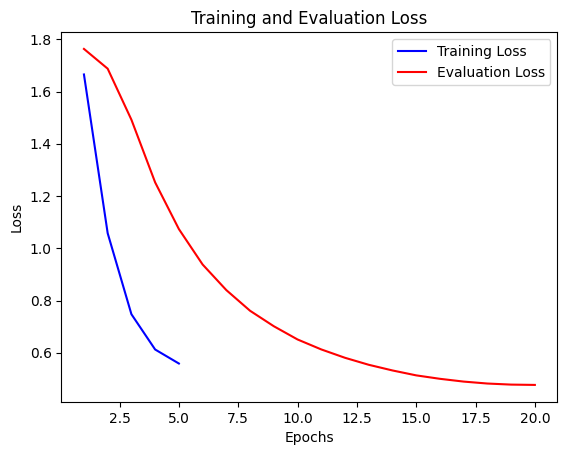

In [16]:
import matplotlib.pyplot as plt
epoch = 20
# Extract training and evaluation loss from log history
train_losses = [entry["loss"] for entry in trainer.state.log_history if "loss" in entry]
eval_losses = [entry["eval_loss"] for entry in trainer.state.log_history if "eval_loss" in entry]
print(len(train_losses))
print(len(eval_losses))
train_losses = train_losses[0:epoch]
eval_losses = eval_losses[0:epoch]

# Plotting
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(eval_losses) + 1), eval_losses, label='Evaluation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

In [19]:
from torch.utils.data import DataLoader

def compute_accuracy(predictions, true_labels):
    predicted_labels = torch.argmax(predictions, dim=-1)
    accuracy = (predicted_labels == true_labels).float().mean().item()
    return accuracy

# Define your test dataloader
batch_size = 20 # Change batch size as needed
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Evaluate on the test set
predictions = []
true_labels = []
for batch in test_dataloader:
    input_ids = batch['input_ids'].to('mps')
    attention_mask = batch['attention_mask'].to('mps')
    labels = batch['labels'].to('mps')

    with torch.no_grad():
        output = model(input_ids=input_ids.squeeze(0), attention_mask=attention_mask.squeeze(0))
        predictions.append(output.logits)
        true_labels.append(labels)

# Concatenate predictions and true labels
predictions = torch.cat(predictions, dim=0)
true_labels = torch.cat(true_labels, dim=0)

# Calculate accuracy
accuracy = compute_accuracy(predictions, true_labels)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.2414814829826355
